In [1]:
# Employee_Prediction.py
# Modular implementation of data analysis, preprocessing, and model building for employee performance prediction

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, roc_curve, roc_auc_score
import pickle

In [2]:
# --- Data Collection ---
# Load the dataset
data = pd.read_csv('D:\Internship_projects\Employee_Productivity_Prediction\garments_worker_productivity.csv')

# --- Descriptive Analysis ---
# Display basic information about the dataset
print("Dataset Info:")
print(data.info())
print("\nDataset Shape:", data.shape)
print("\nDescriptive Statistics:")
print(data.describe(include='all'))


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   flo

In [3]:
data.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


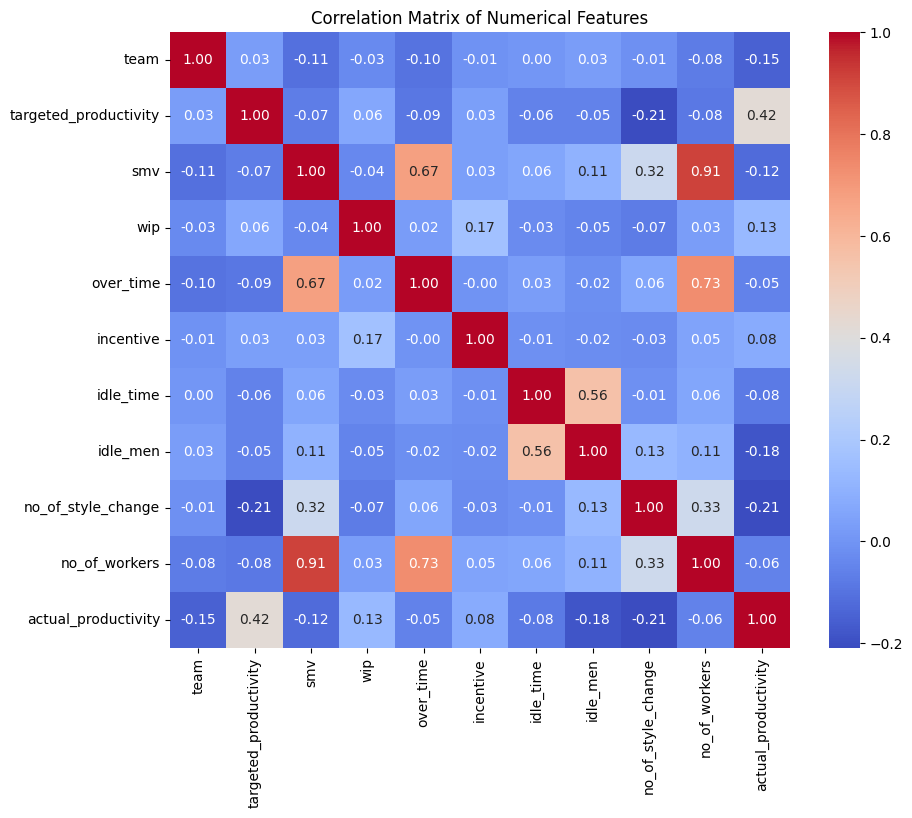

In [4]:
# --- Correlation Analysis ---
# Select numerical columns for correlation matrix
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data[numerical_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [5]:
# --- Data Preprocessing ---
# Check for null values
print("\nNull Values in Dataset:")
print(data.isnull().sum())


Null Values in Dataset:
date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64


In [6]:
# Drop 'wip' column due to high number of missing values
data = data.drop(columns=['wip'])

In [7]:
# Handle date column: Convert to datetime and extract month
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data = data.drop(columns=['date'])
data.head()

,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,month
0,Quarter1,sweing,Thursday,8,0.80,26.16,7080,98,0.0,0,0,59.0,0.940725,1
1,Quarter1,finishing,Thursday,1,0.75,3.94,960,0,0.0,0,0,8.0,0.886500,1
2,Quarter1,sweing,Thursday,11,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570,1
3,Quarter1,sweing,Thursday,12,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570,1
4,Quarter1,sweing,Thursday,6,0.80,25.90,1920,50,0.0,0,0,56.0,0.800382,1


In [8]:
# Handle department column: Merge 'finishing ' and 'finishing'
data['department'] = data['department'].str.strip().replace('finishing ', 'finishing')

In [9]:
# Handle categorical data: Encode 'quarter', 'department', 'day'
class MultiColumnLabelEncoder:
    def __init__(self, columns=None):
        self.columns = columns
        self.label_encoders = {}

    def fit_transform(self, data):
        output = data.copy()
        if self.columns is not None:
            for col in self.columns:
                self.label_encoders[col] = LabelEncoder()
                output[col] = self.label_encoders[col].fit_transform(output[col])
        return output

    def transform(self, data):
        output = data.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = self.label_encoders[col].transform(output[col])
        return output

In [10]:
# Apply MultiColumnLabelEncoder
categorical_cols = ['quarter', 'department', 'day']
mcle = MultiColumnLabelEncoder(columns=categorical_cols)
data = mcle.fit_transform(data)

In [11]:
data

,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,month
0,0,1,3,8,0.80,26.16,7080,98,0.0,0,0,59.0,0.940725,1
1,0,0,3,1,0.75,3.94,960,0,0.0,0,0,8.0,0.886500,1
2,0,1,3,11,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570,1
3,0,1,3,12,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570,1
4,0,1,3,6,0.80,25.90,1920,50,0.0,0,0,56.0,0.800382,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,1,0,5,10,0.75,2.90,960,0,0.0,0,0,8.0,0.628333,3
1193,1,0,5,8,0.70,3.90,960,0,0.0,0,0,8.0,0.625625,3
1194,1,0,5,7,0.65,3.90,960,0,0.0,0,0,8.0,0.625625,3
1195,1,0,5,9,0.75,2.90,1800,0,0.0,0,0,15.0,0.505889,3


In [12]:
# Save the encoder for later use in Flask app
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(mcle, f)

In [13]:
# --- Split Data into Train and Test ---
# Define features (X) and target (y)
X = data.drop(columns=['actual_productivity'])
y = data['actual_productivity']

In [14]:
X.head()

,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,month
0,0,1,3,8,0.80,26.16,7080,98,0.0,0,0,59.0,1
1,0,0,3,1,0.75,3.94,960,0,0.0,0,0,8.0,1
2,0,1,3,11,0.80,11.41,3660,50,0.0,0,0,30.5,1
3,0,1,3,12,0.80,11.41,3660,50,0.0,0,0,30.5,1
4,0,1,3,6,0.80,25.90,1920,50,0.0,0,0,56.0,1


In [15]:
y.head()

0    0.940725
1    0.886500
2    0.800570
3    0.800570
4    0.800382
Name: actual_productivity, dtype: float64

In [16]:
# Convert X to array
X = X.values

In [17]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train.shape ,X_test.shape, y_train.shape, y_test.shape

((957, 13), (240, 13), (957,), (240,))

In [19]:
# --- Model Building ---
# Initialize models
model_lr = LinearRegression()
model_rf = RandomForestRegressor(random_state=42)
model_xgb = XGBRegressor(random_state=42)

In [20]:
# Train models
model_lr.fit(X_train, y_train)


LinearRegression()

In [21]:
model_rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [22]:
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [23]:
# Make predictions
pred_lr = model_lr.predict(X_test)

In [24]:
pred_lr

array([0.61065725, 0.80531334, 0.78929237, 0.75187527, 0.80371556,
       0.83580436, 0.60253767, 0.60426961, 0.69684281, 0.74508249,
       0.70881911, 0.84361343, 0.86637   , 0.60009264, 0.77529767,
       0.79200517, 0.91346293, 0.64955509, 0.57894492, 0.79838296,
       0.91814953, 0.67306171, 0.84105748, 0.83926722, 0.81653369,
       0.62353638, 0.46552022, 0.86910379, 0.64568756, 0.81800469,
       0.80184853, 0.72304407, 0.86427918, 0.71879157, 0.76912161,
       0.7088953 , 0.76115118, 0.86810193, 0.71851083, 0.75752194,
       0.77047964, 0.76502993, 0.69987203, 0.7916774 , 0.70905838,
       0.70427063, 0.69507533, 0.8511652 , 0.78201737, 0.77184342,
       0.8833887 , 0.7915101 , 0.79328002, 0.74290108, 0.79521535,
       0.75399011, 0.71195056, 0.68929182, 0.83591216, 0.46152352,
       0.80048395, 0.76625442, 0.75329215, 0.7801685 , 0.63695731,
       0.72248971, 0.72770018, 0.80810155, 0.74605367, 0.70729826,
       0.79226941, 0.71964977, 0.66452214, 0.76902059, 0.73420

In [25]:
pred_rf = model_rf.predict(X_test)

In [26]:
pred_xgb = model_xgb.predict(X_test)

In [27]:
# --- Model Evaluation ---
# Function to evaluate and print metrics
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{model_name} Performance:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    return mae, mse, r2

# Evaluate all models
lr_metrics = evaluate_model(y_test, pred_lr, "Linear Regression")
rf_metrics = evaluate_model(y_test, pred_rf, "Random Forest")
xgb_metrics = evaluate_model(y_test, pred_xgb, "XGBoost")

# Compare models and select the best based on R2 score
metrics = {
    'Linear Regression': lr_metrics,
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics
}
best_model_name = max(metrics, key=lambda x: metrics[x][2])
print(f"\nBest Model: {best_model_name}")


Linear Regression Performance:
MAE: 0.1075
MSE: 0.0214
R2 Score: 0.1932

Random Forest Performance:
MAE: 0.0670
MSE: 0.0118
R2 Score: 0.5544

XGBoost Performance:
MAE: 0.0740
MSE: 0.0146
R2 Score: 0.4490

Best Model: Random Forest


In [28]:
best_model_name = max(metrics, key=lambda x: metrics[x][2])
print(f"\nBest Model: {best_model_name}")


Best Model: Random Forest


In [29]:
# --- Save the Best Model ---
models = {'Linear Regression': model_lr, 'Random Forest': model_rf, 'XGBoost': model_xgb}
with open('gwp.pkl', 'wb') as f:
    pickle.dump(models[best_model_name], f)
print(f"\nBest model ({best_model_name}) saved as 'gwp.pkl'")


Best model (Random Forest) saved as 'gwp.pkl'


In [30]:
import pickle
with open('gwp.pkl', 'rb') as f:
    model = pickle.load(f)
print(type(model))

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
